In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
# List of tickers to be loaded/downloaded

tickers = tickers_bond = ['IEF', 'SHY', 'TIP', 'TLT', 'HYG', 'LQD', 'AGG', 'BND', 'EMB', 'MUB', 'PFF', '^GSPC', 'TIP', '^GSPC', 'LQD', 'UDN', 'EURUSD=X', '^VIX', 'CL=F', '^IRX', '^FVX', '^TNX', '^TYX']

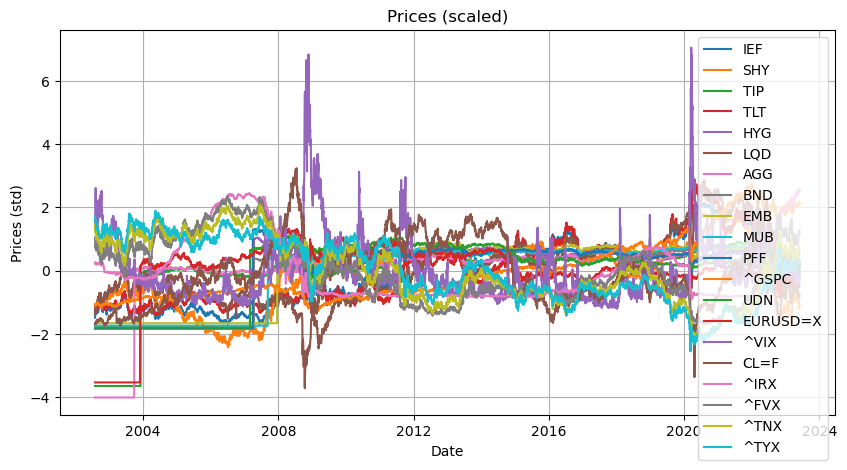

In [3]:
from basic_finance_tools import get_or_download_data, plot_df

# Specify the date range for data load/download
start = '2000-06-01'
end = '2023-06-01'

prices_data = get_or_download_data(tickers, start_date = start, end_date = end).ffill().fillna(0)

plot_df(prices_data, title= 'Prices', unit='USD', scaled=True)

In [4]:
from OptimalLinearSignal import *
from sklearn.preprocessing import StandardScaler

def compute_signal_OLS(pivot: pd.DataFrame, X: pd.DataFrame, 
                           training_size: int = 10, k_components:int=0, 
                           l2_reg:float=1, l1_reg:float=0, p_val:float=0.001,)->pd.DataFrame:
    
    signal = pd.DataFrame(index=pivot.index, columns=pivot.columns)
    
    for index_ticker, ticker in enumerate(pivot.columns):
        model = OptimalLinearSignal(pivot[ticker].diff(), l2_reg, l1_reg, k_principal_components=k_components, p_value_threshold=p_val)
        scaler = StandardScaler()
        #model.make_beta_neutral(pivot[ticker])
        
        # Initialize DataFrame for predicted prices
        signal.iloc[:training_size, index_ticker] = np.nan  # Filling with NaN
        
        # Perform online training and prediction
        for p in range(1, len(pivot) // training_size):
            index_day = p * training_size
            X_train = X.iloc[index_day - training_size: index_day-1, :].replace([np.inf, -np.inf], np.nan).ffill().fillna(0)
            X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
            model.fit(X_train_scaled)
            
            X_day = X.iloc[index_day : index_day + training_size, :].replace([np.inf, -np.inf], np.nan).ffill().fillna(0)
            X_scaled = pd.DataFrame(scaler.transform(X_day), columns=X_day.columns, index=X_day.index)

            predicted_signal = model.predict(X_scaled).values
            corrective_term = model.correct(X_scaled).values
            signal.iloc[index_day : index_day + training_size, index_ticker] = predicted_signal * corrective_term
            
    return signal.ffill()

In [5]:
from basic_finance_tools import compute_position, compute_PNL, compute_metrics, plot_ds_hue, plot_df

def show_strat_OLS(prices: pd.DataFrame, X: pd.DataFrame, ts: int, k:int, l2:float, l1:float=0, pvt:float=0.001):
    """
    Demonstrates a trading strategy based on OLS and visualizes the results.
    """

    print({'ts':ts, 'k':k, 'l2':l2, 'l1':l1, 'pvt':pvt})

    pivot = prices[[prices_data.columns[0]]]
    try: signal = compute_signal_OLS(pivot, X, training_size=ts, k_components=k, l2_reg=l2, l1_reg=l1, p_val=pvt)
    except ValueError as e: return print('No signal, ValueError:', e)
         
    positions = compute_position(signal, prices, threshold=1.5)
    pnl = compute_PNL(positions, prices)
    print(compute_metrics(pnl, positions))
    plot_ds_hue(pnl['DAILY'], pd.Series(signal.abs().mean(axis=1), index=signal.index), 
                title="PNL", #period=['2019-06-01', '2022-06-01']
                )
        
    #plot_df(pd.DataFrame({'Positions (abs)': 25 * 1000 * positions.abs().sum(axis=1) / pnl['DAILY'].std(), 'Cumulative PnL': 25 * 1000 * pnl['DAILY'].cumsum() / pnl['DAILY'].std(),}), title='Position vs PnL', unit='USD (scaled on: 25kUSD / std risk)')

In [6]:
X = pd.concat([prices_data.copy(),
               pd.DataFrame(prices_data.diff(), index=prices_data.index, columns=[str(col)+'.diff' for col in prices_data.columns]),
               pd.DataFrame(prices_data.pct_change(), index=prices_data.index, columns=[str(col)+'.pct_change' for col in prices_data.columns]),
    ], axis=1)

prices = prices_data


{'ts': 60, 'k': 35, 'l2': 10, 'l1': 0.1, 'pvt': 0.001}
{'sharpe_ratio': 0.58, 'turnover': 35.6, 'bips': 14.4, 'effective_sharpe_ratio': 1.33, 'eff_turnover': 184.12}


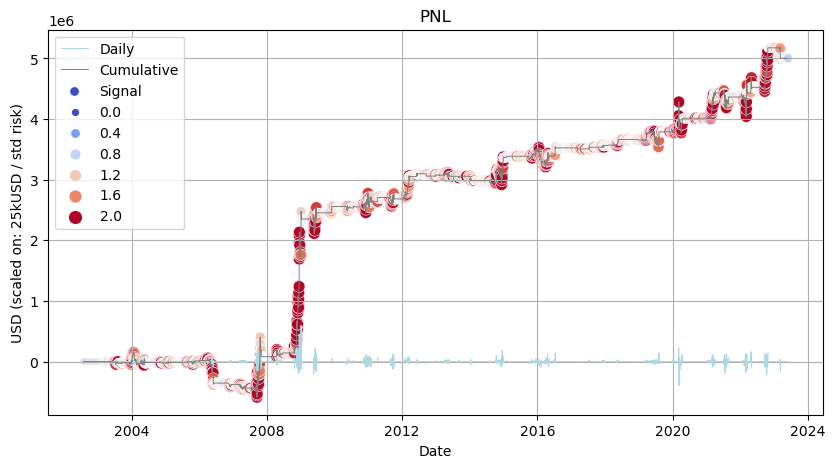

{'ts': 75, 'k': 6, 'l2': 1, 'l1': 0, 'pvt': 0.001}
{'sharpe_ratio': 0.43, 'turnover': 35.5, 'bips': 13.1, 'effective_sharpe_ratio': 0.97, 'eff_turnover': 177.61}


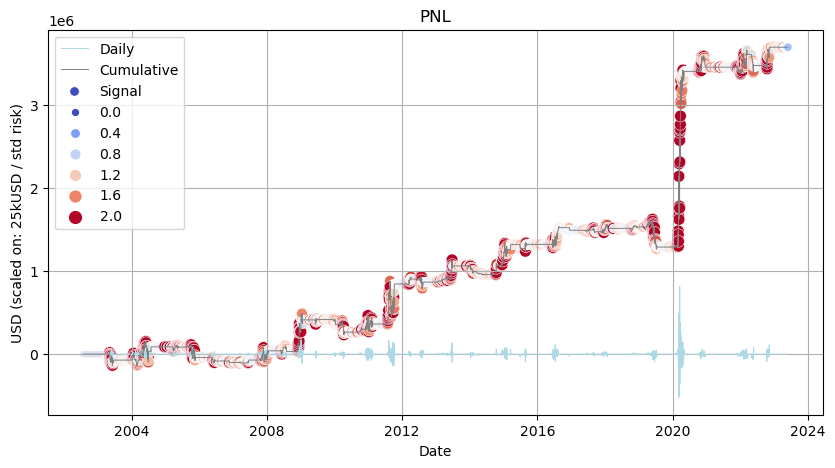

In [7]:
show_strat_OLS(prices, X, ts=60, k=35, l2 = 10, l1=0.1,)
show_strat_OLS(prices, X, ts=75, k=6, l2=1,)

# 2 different trajectory of the PnL using 2 different parameters set

1 / 15 2 / 15 3 / 15 4 / 15 5 / 15 6 / 15 7 / 15 8 / 15 9 / 15 10 / 15 11 / 15 12 / 15 13 / 15 14 / 15 15 / 15 



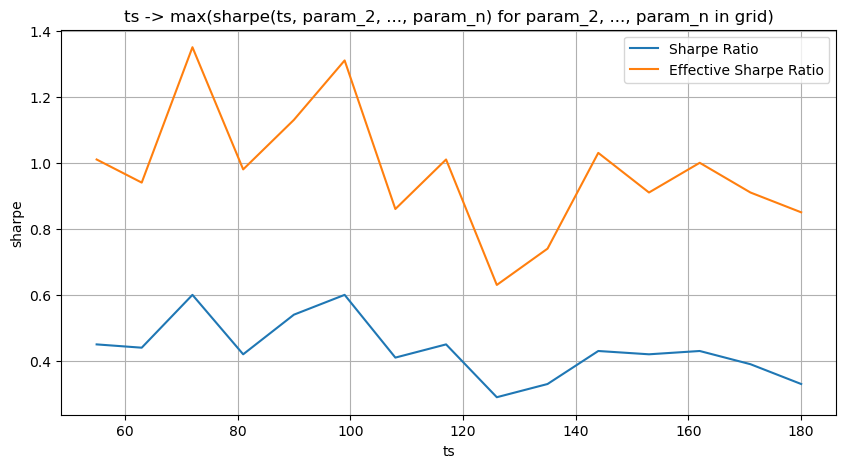

{'ts': 55, 'k': 16, 'l2': 0.1, 'l1': 0, 'pvt': 0.001}
{'sharpe_ratio': 0.45, 'turnover': 33.8, 'bips': 11.2, 'effective_sharpe_ratio': 1.01, 'eff_turnover': 174.35}


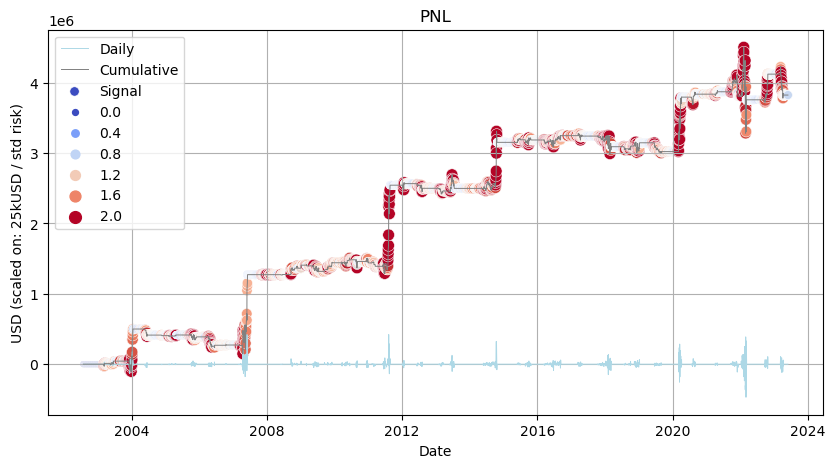

{'ts': 63, 'k': 48, 'l2': 0.1, 'l1': 0, 'pvt': 0.001}
{'sharpe_ratio': 0.44, 'turnover': 31.1, 'bips': 9.7, 'effective_sharpe_ratio': 0.94, 'eff_turnover': 142.65}


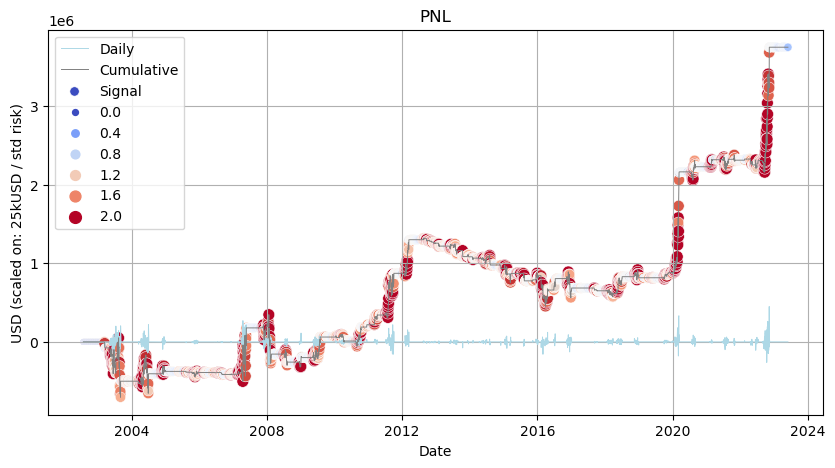

{'ts': 72, 'k': 5, 'l2': 0.1, 'l1': 0, 'pvt': 0.001}
{'sharpe_ratio': 0.6, 'turnover': 38.0, 'bips': 19.3, 'effective_sharpe_ratio': 1.35, 'eff_turnover': 193.33}


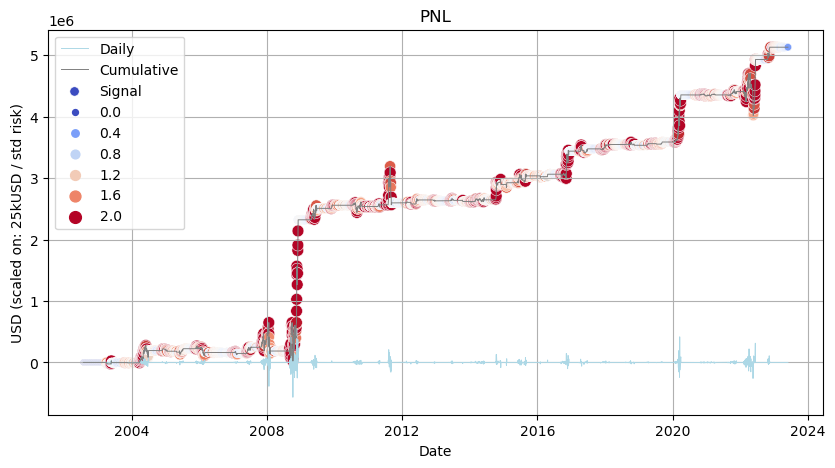

{'ts': 81, 'k': 0, 'l2': 0.1, 'l1': 0, 'pvt': 0.001}
{'sharpe_ratio': 0.42, 'turnover': 39.6, 'bips': 14.8, 'effective_sharpe_ratio': 0.98, 'eff_turnover': 217.01}


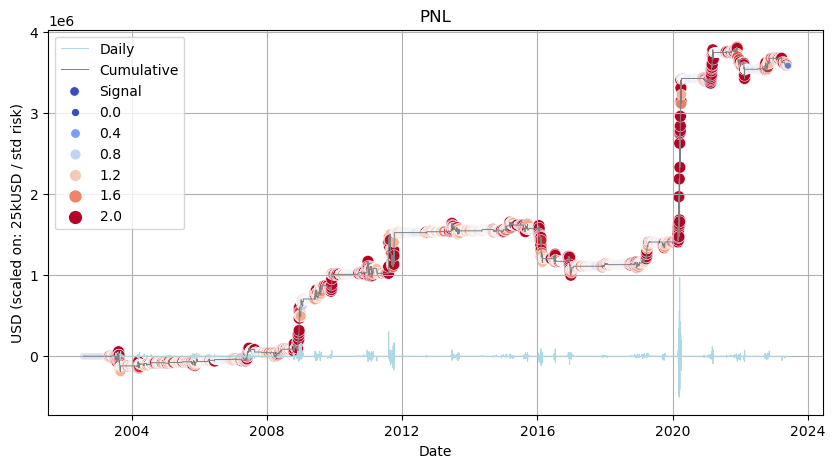

{'ts': 90, 'k': 0, 'l2': 0.1, 'l1': 0, 'pvt': 0.001}
{'sharpe_ratio': 0.54, 'turnover': 33.9, 'bips': 12.4, 'effective_sharpe_ratio': 1.13, 'eff_turnover': 144.93}


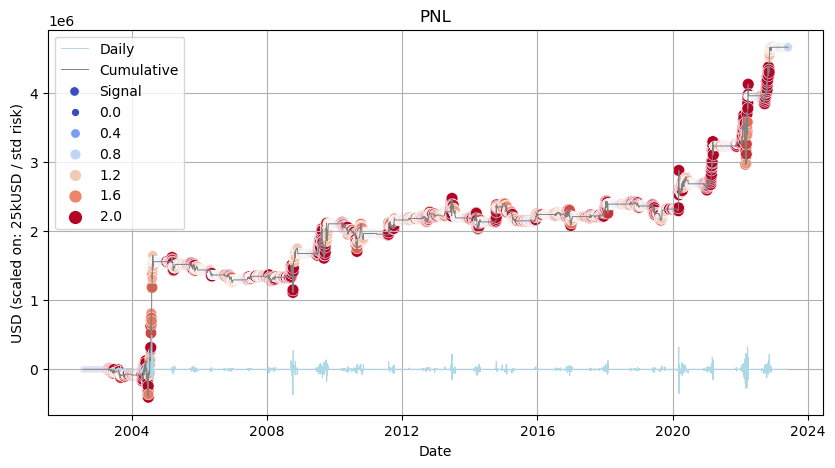

{'ts': 99, 'k': 27, 'l2': 0.1, 'l1': 0, 'pvt': 0.001}
{'sharpe_ratio': 0.6, 'turnover': 32.8, 'bips': 19.8, 'effective_sharpe_ratio': 1.31, 'eff_turnover': 156.41}


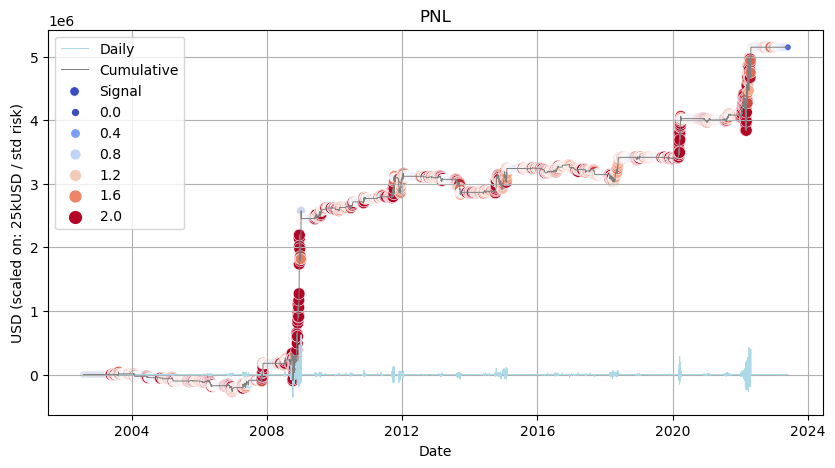

{'ts': 108, 'k': 6, 'l2': 0.1, 'l1': 0, 'pvt': 0.001}
{'sharpe_ratio': 0.41, 'turnover': 32.8, 'bips': 9.9, 'effective_sharpe_ratio': 0.86, 'eff_turnover': 142.97}


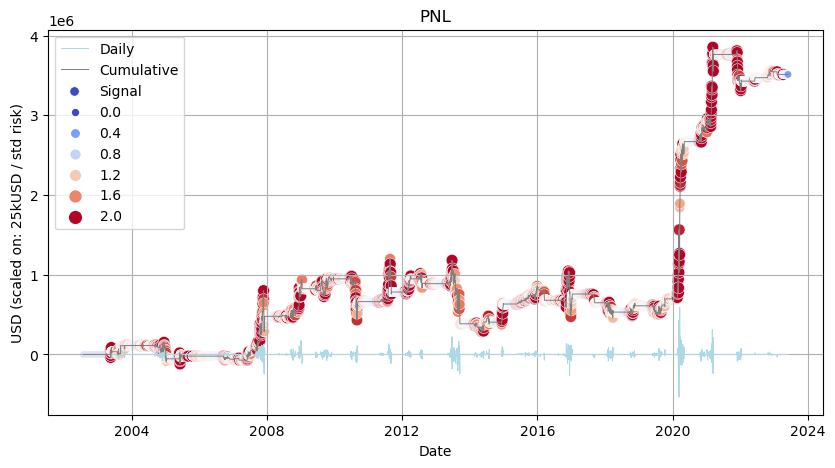

{'ts': 117, 'k': 27, 'l2': 0.1, 'l1': 0, 'pvt': 0.001}
{'sharpe_ratio': 0.45, 'turnover': 31.3, 'bips': 12.3, 'effective_sharpe_ratio': 1.01, 'eff_turnover': 159.46}


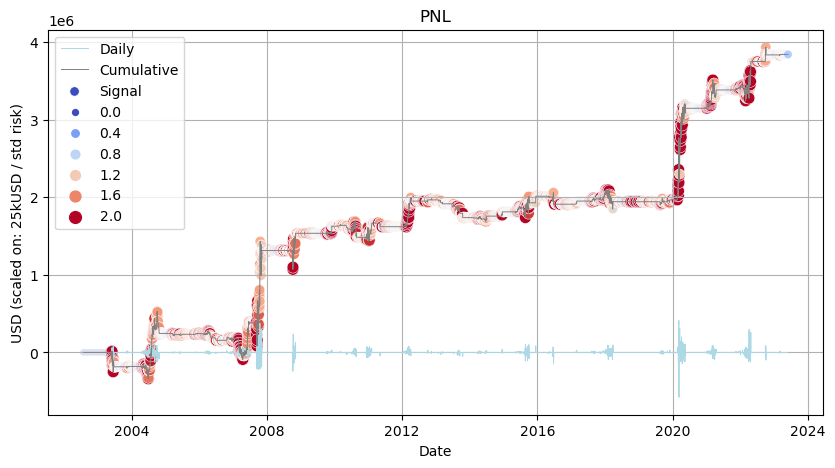

{'ts': 126, 'k': 37, 'l2': 0.1, 'l1': 0, 'pvt': 0.001}
{'sharpe_ratio': 0.29, 'turnover': 35.4, 'bips': 9.7, 'effective_sharpe_ratio': 0.63, 'eff_turnover': 168.35}


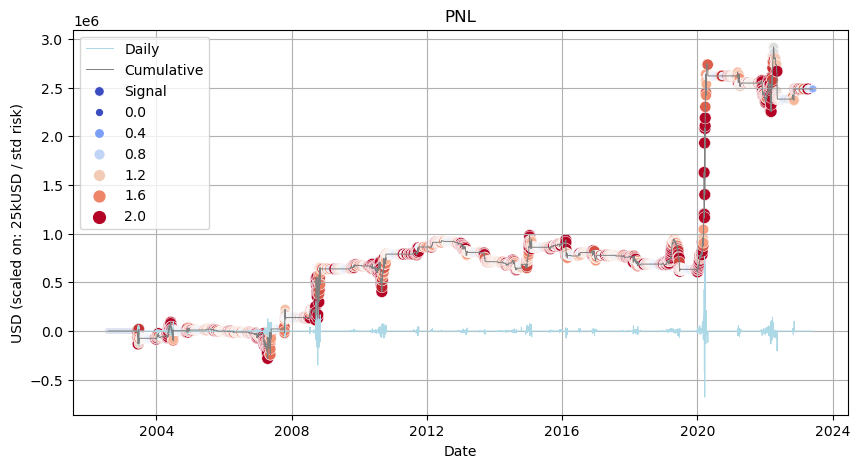

{'ts': 135, 'k': 16, 'l2': 0.1, 'l1': 0, 'pvt': 0.001}
{'sharpe_ratio': 0.33, 'turnover': 40.7, 'bips': 7.7, 'effective_sharpe_ratio': 0.74, 'eff_turnover': 209.0}


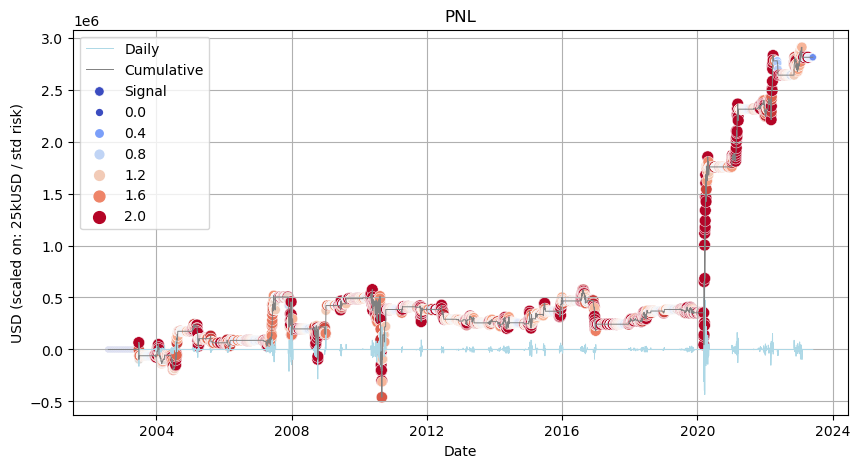

{'ts': 144, 'k': 37, 'l2': 0.1, 'l1': 0, 'pvt': 0.001}
{'sharpe_ratio': 0.43, 'turnover': 44.0, 'bips': 10.9, 'effective_sharpe_ratio': 1.03, 'eff_turnover': 248.89}


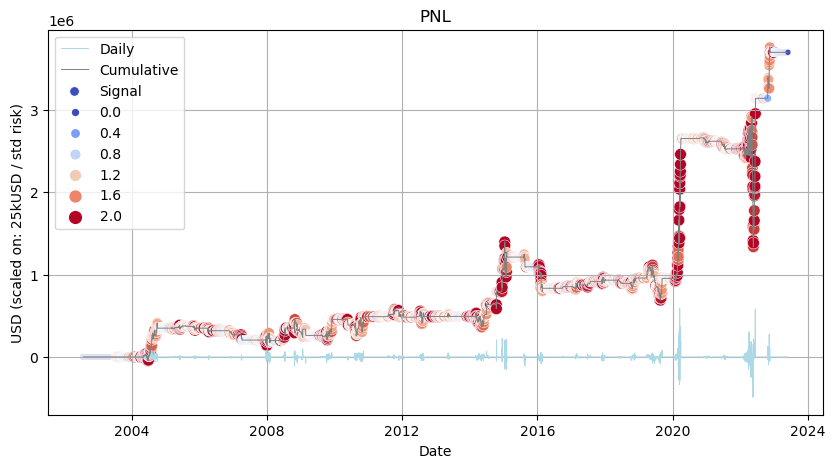

{'ts': 153, 'k': 16, 'l2': 0.1, 'l1': 0, 'pvt': 0.001}
{'sharpe_ratio': 0.42, 'turnover': 37.9, 'bips': 12.4, 'effective_sharpe_ratio': 0.91, 'eff_turnover': 181.97}


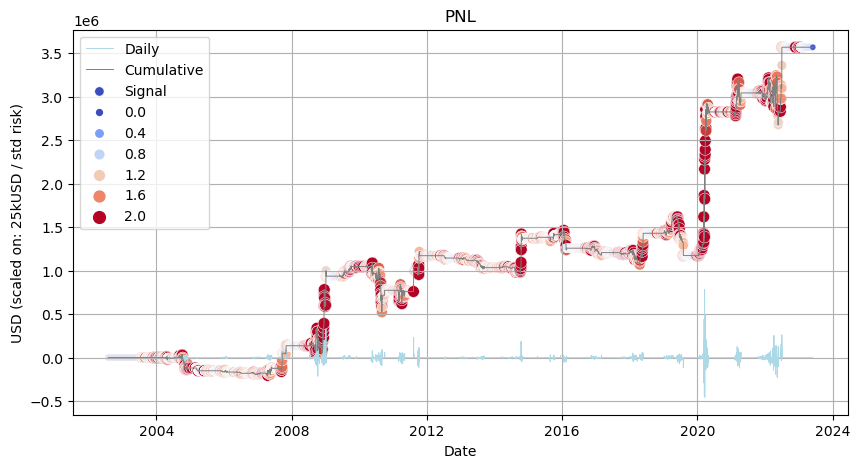

{'ts': 162, 'k': 27, 'l2': 0.1, 'l1': 0, 'pvt': 0.001}
{'sharpe_ratio': 0.43, 'turnover': 28.2, 'bips': 20.4, 'effective_sharpe_ratio': 1.0, 'eff_turnover': 151.44}


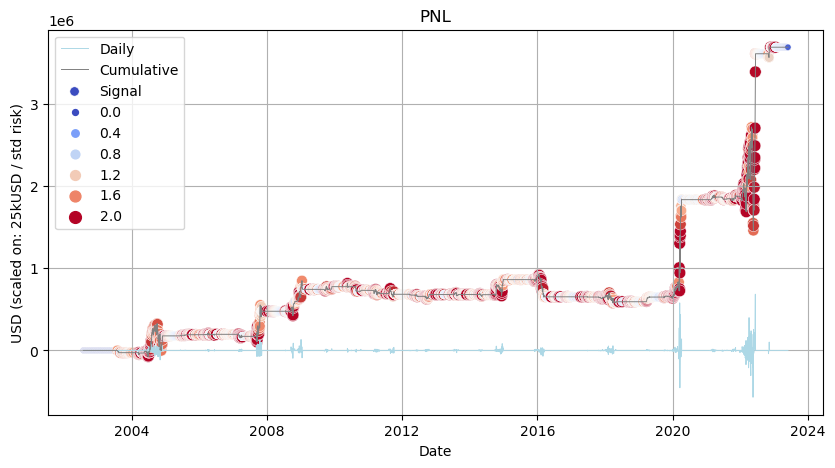

{'ts': 171, 'k': 6, 'l2': 0.1, 'l1': 0, 'pvt': 0.001}
{'sharpe_ratio': 0.39, 'turnover': 33.8, 'bips': 11.1, 'effective_sharpe_ratio': 0.91, 'eff_turnover': 189.45}


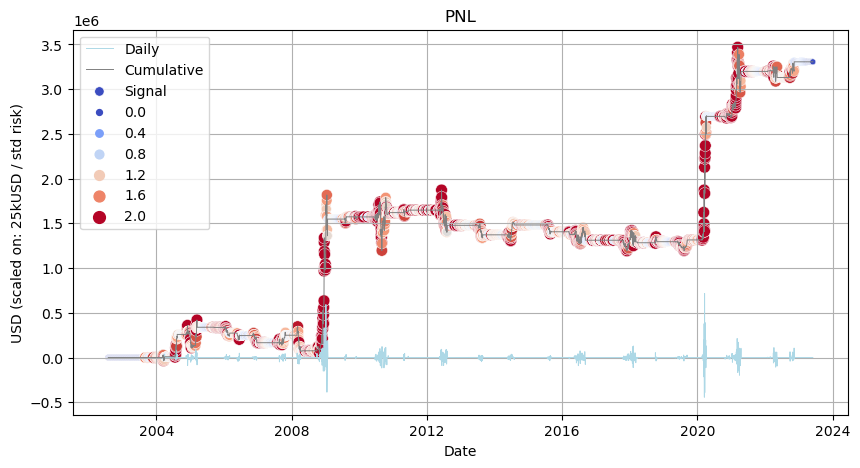

{'ts': 180, 'k': 0, 'l2': 0.1, 'l1': 0, 'pvt': 0.001}
{'sharpe_ratio': 0.33, 'turnover': 41.0, 'bips': 12.8, 'effective_sharpe_ratio': 0.85, 'eff_turnover': 272.62}


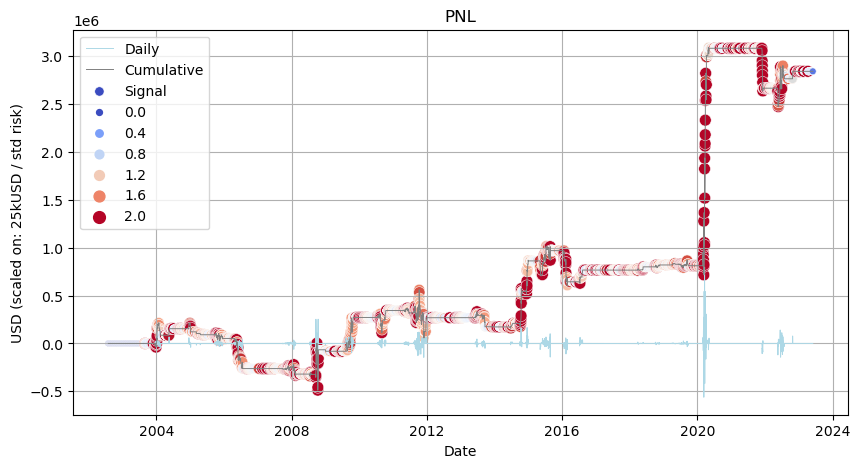

In [8]:
# Grid search optimization for wz1, wz2, wvt parameters for zscore strat
from basic_finance_tools import axial_grid_search, grid_search

def evaluate_OLS_strat(ts: int, k:int = 1, l2:float=1, l1:float=0, pvt:float=0.001, metric:str='sharpe_ratio') -> float:

    global prices, X
    
    pivot = prices[[prices.columns[0]]]
    try: signal = compute_signal_OLS(pivot, X, training_size=ts, k_components=k, l2_reg=l2, l1_reg=l1, p_val=pvt)
    except ValueError: return 0 
    positions = compute_position(signal, prices, threshold=1.5)
    pnl = compute_PNL(positions, prices)
    return compute_metrics(pnl, positions)[metric]

# Define parameter ranges for grid search
param_grid = {
    'ts': np.linspace(55, 180, 15, dtype=int).tolist(),
    'k': [0, 1, 3, 5,] + np.linspace(6, len(X.columns)-1, 6, dtype=int).tolist(),
    'l2': [0.1],# 10, 0, 0.1, 0.5, 1, ],
    'l1': [0],
    'pvt': [0.001]#, 0.01, 0.1, 0.4, 0.9]

} # Note that there is just a few params for each 'ts'

best_param_values, _ = axial_grid_search(evaluate_OLS_strat, param_dict=param_grid, param_selected='ts')

for params in best_param_values: show_strat_OLS(prices, X, **params)  